<a href="https://colab.research.google.com/github/stanislavfort/ensemble-landscape-cuts/blob/main/basic_loss_cuts_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redoing loss landscapes cuts from *Deep Ensembles: A Loss Landscape Perspective* (https://arxiv.org/abs/1912.02757)
The models are only trained for a few epochs for illustration purposes but you can of course vary it as you wish to match the paper

The plot you can expect looks like this:

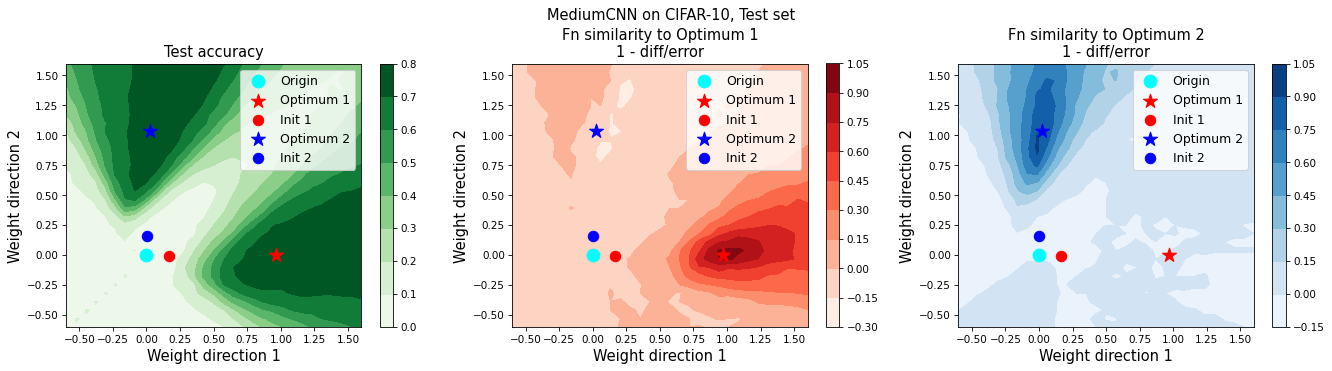

And the second plot for the optimized path looks like this:

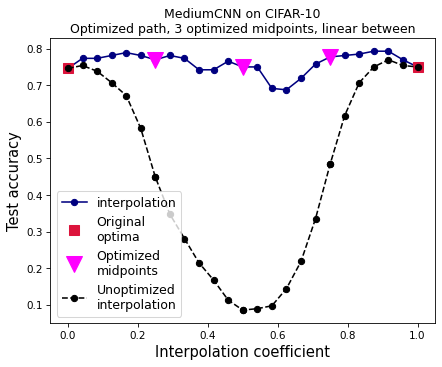

# Imports

In [1]:
!nvidia-smi

Fri Oct 21 15:17:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import torchvision
import torchvision.transforms as transforms

# Data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


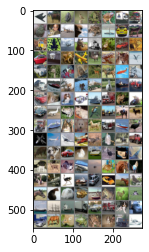

plane horse bird  bird  frog  frog  truck truck frog  cat   plane bird  frog  ship  car   horse truck frog  plane horse truck deer  car   deer  car   dog   frog  plane deer  frog  deer  bird  car   bird  dog   bird  deer  horse plane horse truck ship  deer  dog   truck horse ship  truck car   cat   dog   plane ship  truck frog  cat   car   plane frog  dog   bird  plane horse horse truck ship  cat   dog   horse truck ship  bird  plane plane plane truck deer  dog   horse truck deer  dog   car   dog   ship  bird  car   plane dog   deer  cat   plane ship  deer  horse bird  horse plane bird  ship  car   car   horse bird  horse cat   dog   frog  ship  frog  deer  cat   ship  ship  ship  truck car   truck dog   truck car   horse deer  frog  frog  dog   truck ship 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class MediumCNN(nn.Module):
    def __init__(self, channels = [64,128,256,256], classes=10):
        super().__init__()
        
        self.channels = channels
        self.classes = classes
        self.convs_list = nn.ModuleList()
        self.pools_list = nn.ModuleList()
        for i in range(len(channels)):
          channels_in = channels[i-1] if i > 0 else 3
          channels_out = channels[i]
          kernel_size = 3
          conv_now = nn.Conv2d(channels_in, channels_out, kernel_size, stride=1, padding="same").to(device)
          self.convs_list.append(conv_now)
          pool_now = nn.MaxPool2d(2, 2).to(device)
          self.pools_list.append(pool_now)

        output_dim = 4096 #not sure
        self.fc = nn.Linear(output_dim, classes)

    def forward(self, x):
        # print(x.shape)
        for i in range(len(self.convs_list)):
          if i < len(self.convs_list) - 1:
            x = self.pools_list[i](F.relu(self.convs_list[i](x)))
          else:
            x = self.convs_list[i](x)
          # print(i,x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = self.fc(x).to(device)
        # print(x.shape)
        return x


net = MediumCNN().to(device)

# Getting the optima

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [8]:
def get_loss_acc_preds(net, data_generator=testloader, max_count = None):

  correct = 0
  total = 0

  net = net.to(device)

  # since we're not training, we don't need to calculate the gradients for our outputs

  with torch.no_grad():

      all_outputs = []
      all_labels = []
      all_losses = []

      for data in data_generator:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = net(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)

          all_outputs.append(outputs.data)
          all_labels.append(labels)
          all_losses.append(loss)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          if max_count is not None and total >= max_count:
            break

  acc = float(correct) / float(total)

  end_index = -1 if max_count is None else max_count

  return acc, torch.stack(all_losses), torch.concat(all_outputs,axis=0)[:end_index], torch.concat(all_labels,axis=0)[:end_index]


In [9]:
import copy

def train_model(
    epochs = 2,
    lr = 1e-3,
    random_seed = 12523423,
):

  torch.manual_seed(random_seed)

  net = MediumCNN().to(device)
  optimizer = optim.Adam(net.parameters(), lr=lr)
  net.train()

  net_init_state_dict = copy.deepcopy(net.state_dict())

  for epoch in range(epochs):  # loop over the dataset multiple times

      running_losses = []
      running_accs = []

      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          # inputs, labels = data # for CPU
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_losses.append(loss.item())
          running_accs.append(torch.mean(torch.Tensor.double(torch.argmax(outputs,axis=1) == labels)).detach().cpu().numpy())

          if i % 100 == 0:    # print every 2000 mini-batches

              print(f"e={epoch} i={i} loss={np.mean(running_losses)} acc={np.mean(running_accs)}")
              
              running_losses = []
              running_accs = []

  print('Finished Training')

  test_acc, _, _, _ = get_loss_acc_preds(net, data_generator=testloader, max_count = None)
  print(f"Test accuracy = {test_acc}")

  return net, net_init_state_dict

## Getting the 2 original optima

In [10]:
net1, net1_init_state_dict = train_model(
    epochs = 5,
    random_seed = 12321,
)

net2, net2_init_state_dict = train_model(
    epochs = 5,
    random_seed = 96843,
)

e=0 i=0 loss=2.311140537261963 acc=0.0625
e=0 i=100 loss=1.7217035794258118 acc=0.369296875
e=0 i=200 loss=1.3613442361354828 acc=0.507734375
e=0 i=300 loss=1.2065076261758805 acc=0.568203125
e=1 i=0 loss=0.9669221639633179 acc=0.65625
e=1 i=100 loss=0.9555712336301804 acc=0.66640625
e=1 i=200 loss=0.9319099479913712 acc=0.6703125
e=1 i=300 loss=0.8730290710926056 acc=0.693359375
e=2 i=0 loss=0.6581397652626038 acc=0.8046875
e=2 i=100 loss=0.735248311161995 acc=0.73859375
e=2 i=200 loss=0.7238928344845772 acc=0.746015625
e=2 i=300 loss=0.7239130431413651 acc=0.7459375
e=3 i=0 loss=0.531383752822876 acc=0.8125
e=3 i=100 loss=0.5991419786214829 acc=0.791640625
e=3 i=200 loss=0.61589599609375 acc=0.783828125
e=3 i=300 loss=0.6138584846258164 acc=0.7896875
e=4 i=0 loss=0.4141259789466858 acc=0.859375
e=4 i=100 loss=0.49276131093502046 acc=0.8290625
e=4 i=200 loss=0.5034823781251907 acc=0.821328125
e=4 i=300 loss=0.517673200070858 acc=0.821796875
Finished Training
Test accuracy = 0.7535
e=0

# Landscape utils

In [11]:
def flatten_param_dict(param_dict, keys):
  all_vals = []
  all_vals_without_bn = []
  all_shapes = []
  for key in keys:
    all_vals.append(param_dict[key].reshape([-1]))
    all_shapes.append(list(param_dict[key].shape))
    if "bn" not in key and "num_batches_tracked" not in key:
      all_vals_without_bn.append(param_dict[key].reshape([-1]))
  return torch.concat(all_vals,axis=-1), all_shapes, torch.concat(all_vals_without_bn,axis=-1)

def reform_params_dict(flat_vector, shapes, keys):
  counter = 0
  param_dict = dict()
  for i,shape in enumerate(shapes): 
    size_now = int(np.prod(shape) if shape is not None else 1)
    # print("size_now",size_now)
    vals_now = flat_vector[counter:counter+size_now]
    param_dict[keys[i]] = vals_now.reshape(shape)
    counter += size_now
  return param_dict


In [12]:
sd1 = dict(net.state_dict())

keys = list(sd1.keys())

vals, shapes, vals_nobn = flatten_param_dict(sd1, keys)

reformed_dict = reform_params_dict(vals, shapes, keys)  

In [13]:
for key in reformed_dict.keys():
  assert torch.sum(reformed_dict[key] != sd1[key]) == 0

In [14]:
def linear_combination(alpha, state_dict1, beta, state_dict2):
    state_dict_now = {k: alpha * state_dict1[k].cuda() + beta * state_dict2[k].cuda()
                for k in state_dict1.keys()}
    return state_dict_now

def dot(state_dict1, state_dict2):
    dot = torch.sum(torch.Tensor([torch.sum(state_dict1[k].cuda() * state_dict2[k].cuda()) for k in state_dict1.keys()]))
    return dot

def multiply(alpha, state_dict1):
  return {k: alpha * state_dict1[k].cuda() for k in state_dict1.keys()}

def norm(state_dict1):
  return torch.sqrt(torch.sum(torch.Tensor([torch.sum(state_dict1[k].cuda()**2) for k in state_dict1.keys()])))

def cos(state_dict1, state_dict2):
  dot = torch.sum(torch.Tensor([torch.sum(state_dict1[k].cuda() * state_dict2[k].cuda()) for k in state_dict1.keys()]))
  R1 = norm(state_dict1)
  R2 = norm(state_dict2)
  return dot / R1 / R2

def zeros(state_dict1):
  return {k: 0.0*state_dict1[k].cuda() for k in state_dict1.keys()}

def ones(state_dict1):
  return {k: torch.ones_like(state_dict1[k].cuda()) for k in state_dict1.keys()}


# Landscape cuts

In [32]:
#@title

def make_landscape_cuts(
    state_dict1, # model 1
    state_dict2, # model 2
    number_of_images = 256, # number of test images to evaluate on
    x_steps = 31, # steps of the landscape cut exploration
    y_steps = 32, # steps of the landscape cut exploration
):

  sd1 = state_dict1
  sd2 = state_dict2

  print(f"R1={norm(sd1)} R1={norm(sd2)} cos={cos(sd1,sd2)}")

  point0 = zeros(sd1)
  point1 = sd1
  point2 = sd2

  basis1 = linear_combination(1, point1, -1, point0)
  length1 = norm(basis1)
  basis1_normed = multiply(1.0/length1, basis1)

  basis2 = linear_combination(1, point2, -1, point0)
  along = dot(basis2, basis1_normed)
  basis2 = linear_combination(1.0, basis2, -1.0*along, basis1_normed)
  length2 = norm(basis2)
  basis2_normed = multiply(1.0/length2, basis2)

  R = (length1+length2)/2.0

  ts1 = np.linspace(-0.6,1.6,x_steps)
  ts2 = np.linspace(-0.6,1.6,y_steps)

  grid_test_accs = np.zeros((len(ts1),len(ts2)))
  grid_test_accs = np.zeros((len(ts1),len(ts2)))
  grid_test_preds = np.zeros((len(ts1),len(ts2),number_of_images,10))
  grid_test_labels = np.zeros((len(ts1),len(ts2),number_of_images))

  for i1,t1 in enumerate(ts1):
    print(f"{i1}/{len(ts1)}")
    for i2,t2 in enumerate(ts2):

      point_now = linear_combination(
          1.0, point0,
          t1*R, basis1_normed   
      )
      point_now = linear_combination(
          1.0, point_now,
          t2*R, basis2_normed   
      )

      net.load_state_dict(point_now)
      
      test_acc, _, preds, labels = get_loss_acc_preds(net, data_generator=testloader, max_count = number_of_images)
      grid_test_accs[i1,i2] = test_acc
      grid_test_preds[i1,i2] = preds.detach().cpu().numpy()
      grid_test_labels[i1,i2] = labels.detach().cpu().numpy()

  def get_coords(state_dict):
    x = dot(linear_combination(1.0,state_dict,-1.0,point0), basis1_normed) / R
    y = dot(linear_combination(1.0,state_dict,-1.0,point0), basis2_normed) / R
    return x,y

  net.load_state_dict(point1)
  _, _, preds1, labels1 = get_loss_acc_preds(net, max_count=number_of_images)
  net.load_state_dict(point2)
  _, _, preds2, labels2 = get_loss_acc_preds(net, max_count=number_of_images)

  fig = plt.figure(figsize=(3*6,5),dpi=75)
  fig.patch.set_facecolor('white')

  plt.suptitle("MediumCNN on CIFAR-10, Test set",fontsize=14)


  plt.subplot(1,3,1)
  plt.title("Test accuracy",fontsize=14)
  plt.contourf(ts1, ts2, grid_test_accs.T,cmap = plt.cm.Greens)
  plt.colorbar()

  x,y = get_coords(point0)
  plt.scatter([x],[y],marker="o",color="aqua",s=150,label="Origin")

  x,y = get_coords(point1)
  plt.scatter([x],[y],marker="*",color="red",s=200,label="Optimum 1")

  x,y = get_coords(net1_init_state_dict)
  plt.scatter([x],[y],marker="o",color="red",s=100,label="Init 1")

  x,y = get_coords(point2)
  plt.scatter([x],[y],marker="*",color="blue",s=200,label="Optimum 2")

  x,y = get_coords(net2_init_state_dict)
  plt.scatter([x],[y],marker="o",color="blue",s=100,label="Init 2")

  plt.xlabel("Weight direction 1",fontsize=14)
  plt.ylabel("Weight direction 2",fontsize=14)

  plt.legend(fontsize = 12)

  plt.subplot(1,3,2)
  plt.title("Fn similarity to Optimum 1\n1 - diff/error",fontsize=14)

  diffs = np.argmax(grid_test_preds,axis=-1) == np.argmax(preds1.detach().cpu().numpy(),axis=-1).reshape([1,1,number_of_images])
  accs = np.argmax(grid_test_preds,axis=-1) == labels1.detach().cpu().numpy().reshape([1,1,number_of_images])
  data = np.mean(1-diffs,axis=-1) / np.mean(1-accs,axis=-1)

  plt.contourf(ts1, ts2, 1-data.T,cmap = plt.cm.Reds)
  plt.colorbar()

  x,y = get_coords(point0)
  plt.scatter([x],[y],marker="o",color="aqua",s=150,label="Origin")

  x,y = get_coords(point1)
  plt.scatter([x],[y],marker="*",color="red",s=200,label="Optimum 1")

  x,y = get_coords(net1_init_state_dict)
  plt.scatter([x],[y],marker="o",color="red",s=100,label="Init 1")

  x,y = get_coords(point2)
  plt.scatter([x],[y],marker="*",color="blue",s=200,label="Optimum 2")

  x,y = get_coords(net2_init_state_dict)
  plt.scatter([x],[y],marker="o",color="blue",s=100,label="Init 2")

  plt.xlabel("Weight direction 1",fontsize=14)
  plt.ylabel("Weight direction 2",fontsize=14)

  plt.legend(fontsize = 12)

  plt.subplot(1,3,3)
  plt.title("Fn similarity to Optimum 2\n1 - diff/error",fontsize=14)

  diffs = np.argmax(grid_test_preds,axis=-1) == np.argmax(preds2.detach().cpu().numpy(),axis=-1).reshape([1,1,number_of_images])
  accs = np.argmax(grid_test_preds,axis=-1) == labels2.detach().cpu().numpy().reshape([1,1,number_of_images])
  data = np.mean(1-diffs,axis=-1) / np.mean(1-accs,axis=-1)

  plt.contourf(ts1, ts2, 1-data.T,cmap = plt.cm.Blues)
  plt.colorbar()

  x,y = get_coords(point0)
  plt.scatter([x],[y],marker="o",color="aqua",s=150,label="Origin")

  x,y = get_coords(point1)
  plt.scatter([x],[y],marker="*",color="red",s=200,label="Optimum 1")

  x,y = get_coords(net1_init_state_dict)
  plt.scatter([x],[y],marker="o",color="red",s=100,label="Init 1")

  x,y = get_coords(point2)
  plt.scatter([x],[y],marker="*",color="blue",s=200,label="Optimum 2")

  x,y = get_coords(net2_init_state_dict)
  plt.scatter([x],[y],marker="o",color="blue",s=100,label="Init 2")

  plt.xlabel("Weight direction 1",fontsize=14)
  plt.ylabel("Weight direction 2",fontsize=14)

  plt.legend(fontsize = 12)

  plt.tight_layout()

  fig.subplots_adjust(top=0.83)

  plt.show()

  return point1, point2

R1=38.263755798339844 R1=41.49324417114258 cos=0.02389371395111084
0/11
1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11


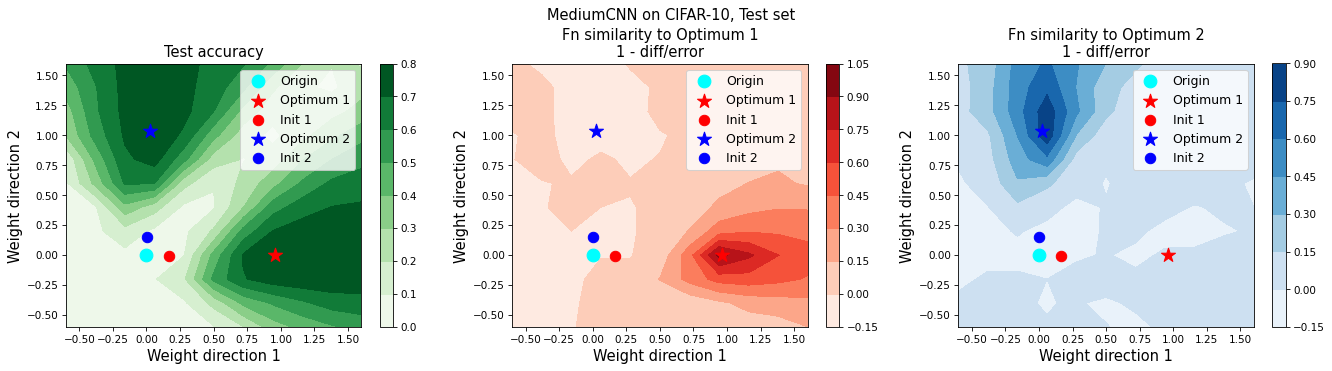

In [33]:
point1, point2 = make_landscape_cuts(
    net1.state_dict(),
    net2.state_dict(),
    number_of_images = 256, # number of test images to evaluate on
    x_steps = 11, # steps of the landscape cut exploration
    y_steps = 12, # steps of the landscape cut exploration
)

# Getting the optimized path between optima

In [31]:
def optimize_at_point_on_plane(
    start_point,
    directions_list,
    bring_back_every = 100,
    epochs = 2,
    lr = 1e-3,
    random_seed = 12523423,
    verbose = True,
):

  torch.manual_seed(random_seed)

  net = MediumCNN().to(device)
  optimizer = optim.Adam(net.parameters(), lr=lr)

  #loading the midpoint start
  net.load_state_dict(start_point)
  net.train()

  for epoch in range(epochs):  # loop over the dataset multiple times

      running_losses = []
      running_accs = []

      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          # inputs, labels = data # for CPU
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_losses.append(loss.item())
          running_accs.append(torch.mean(torch.Tensor.double(torch.argmax(outputs,axis=1) == labels)).detach().cpu().numpy())

          # bringing it back to the plane
          if bring_back_every is None or i % bring_back_every == 0:
            def bring_back():
              state_dict = net.state_dict()
              vector_from_start = linear_combination(1.0,state_dict,-1.0,start_point)
              for dir in directions_list:
                dir_normed = multiply(1/norm(dir),dir)
                projection = dot(vector_from_start,dir_normed)
                vector_from_start = linear_combination(1.0,vector_from_start,-1.0*projection,dir_normed)
              state_dict = linear_combination(1.0,start_point,1.0,vector_from_start)
              net.load_state_dict(state_dict) # loading it back
              if verbose:
                print("Point brought back to the plane")
            bring_back()


          if i % 100 == 0:    # print every 2000 mini-batches

              print(f"e={epoch} i={i} loss={np.mean(running_losses)} acc={np.mean(running_accs)}")
              
              running_losses = []
              running_accs = []

  print('Finished Training')

  bring_back()

  test_acc, _, _, _ = get_loss_acc_preds(net, data_generator=testloader, max_count = None)
  print(f"Test accuracy = {test_acc}")

  return net
  

In [22]:
chain_steps = 3
ts = np.linspace(0,1.0,chain_steps+2)[1:-1]

optimized_mid_points = []

for i,t in enumerate(ts):

  print(f"Chain step {i}/{chain_steps}")

  optimized_mid_net = optimize_at_point_on_plane(
      linear_combination(1-t,point1,t,point2),
      [linear_combination(1.0,point2,-1.0,point1)],
      bring_back_every = 10,
      epochs = 2,
      lr = 1e-3,
      random_seed = 12523423,
      verbose=False,
  )

  optimized_mid_points.append(copy.deepcopy(optimized_mid_net.state_dict()))



Chain step 0/3
e=0 i=0 loss=1.5975775718688965 acc=0.5625
e=0 i=100 loss=0.613262705206871 acc=0.789609375
e=0 i=200 loss=0.5375700315833092 acc=0.80921875
e=0 i=300 loss=0.5340280178189277 acc=0.8159375
e=1 i=0 loss=0.45674675703048706 acc=0.8671875
e=1 i=100 loss=0.4124797281622887 acc=0.858203125
e=1 i=200 loss=0.4462775850296021 acc=0.84453125
e=1 i=300 loss=0.4596616765856743 acc=0.838046875
Finished Training
Test accuracy = 0.7608
Chain step 1/3
e=0 i=0 loss=2.297041893005371 acc=0.2109375
e=0 i=100 loss=1.1165151250362397 acc=0.6059375
e=0 i=200 loss=0.8088989460468292 acc=0.716328125
e=0 i=300 loss=0.7506578505039215 acc=0.741875
e=1 i=0 loss=0.7127130031585693 acc=0.8046875
e=1 i=100 loss=0.5778715202212333 acc=0.800703125
e=1 i=200 loss=0.5873299613595009 acc=0.79890625
e=1 i=300 loss=0.5914571791887283 acc=0.792578125
Finished Training
Test accuracy = 0.766
Chain step 2/3
e=0 i=0 loss=1.4794212579727173 acc=0.59375
e=0 i=100 loss=0.5696715947985649 acc=0.807265625
e=0 i=200 

## Connecting points

In [23]:
all_points = [point1] + optimized_mid_points + [point2]

all_ts = []
all_acc = []

steps_in_between = 5

for i in range(len(all_points)-1):
  pA = all_points[i]
  pB = all_points[i+1]

  ts_between = np.linspace(0,1,steps_in_between+2)
  for j,t in enumerate(ts_between):
    p_now = linear_combination(1-t,pA,t,pB)
    net.load_state_dict(p_now)
    test_acc, _, _, _ = get_loss_acc_preds(net, data_generator=testloader, max_count = 256)

    t_start = i*1.0/(len(all_points)-1)
    t_end = (i+1)*1.0/(len(all_points)-1)
    t_all = t_start + (t_end-t_start)*t

    all_ts.append(t_all)
    all_acc.append(test_acc)

    print(f"link={i} step={j}/{len(ts_between)} acc={test_acc}")




link=0 step=0/7 acc=0.765625
link=0 step=1/7 acc=0.77734375
link=0 step=2/7 acc=0.7734375
link=0 step=3/7 acc=0.78515625
link=0 step=4/7 acc=0.78515625
link=0 step=5/7 acc=0.765625
link=0 step=6/7 acc=0.7421875
link=1 step=0/7 acc=0.7421875
link=1 step=1/7 acc=0.73828125
link=1 step=2/7 acc=0.72265625
link=1 step=3/7 acc=0.72265625
link=1 step=4/7 acc=0.71875
link=1 step=5/7 acc=0.76953125
link=1 step=6/7 acc=0.8046875
link=2 step=0/7 acc=0.8046875
link=2 step=1/7 acc=0.76953125
link=2 step=2/7 acc=0.734375
link=2 step=3/7 acc=0.73046875
link=2 step=4/7 acc=0.74609375
link=2 step=5/7 acc=0.78125
link=2 step=6/7 acc=0.76953125
link=3 step=0/7 acc=0.76953125
link=3 step=1/7 acc=0.78515625
link=3 step=2/7 acc=0.79296875
link=3 step=3/7 acc=0.80078125
link=3 step=4/7 acc=0.796875
link=3 step=5/7 acc=0.8046875
link=3 step=6/7 acc=0.76171875


## Accuracies for plotting

In [24]:
net.load_state_dict(point1)
test_acc1, _, _, _ = get_loss_acc_preds(net, data_generator=testloader, max_count = 256)

net.load_state_dict(point2)
test_acc2, _, _, _ = get_loss_acc_preds(net, data_generator=testloader, max_count = 256)

test_mids = []
for optimized_point in optimized_mid_points:
  net.load_state_dict(optimized_point)
  test_mid, _, _, _ = get_loss_acc_preds(net, data_generator=testloader, max_count = 256)
  test_mids.append(test_mid)

In [25]:
unoptimized_mid_accs = []
for t in all_ts:
  net.load_state_dict(linear_combination(1-t,point1,t,point2))
  test_acc, _, _, _ = get_loss_acc_preds(net, data_generator=testloader, max_count = 256)
  unoptimized_mid_accs.append(test_acc)


# A plot for optimized connector

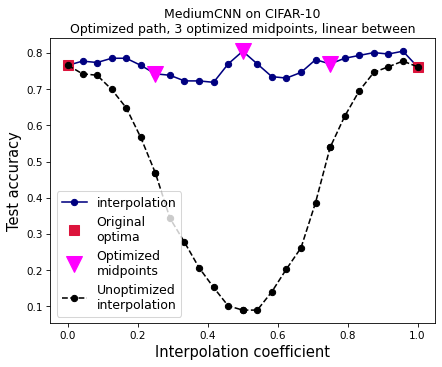

In [26]:
fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')


plt.title(f"MediumCNN on CIFAR-10\nOptimized path, {len(optimized_mid_points)} optimized midpoints, linear between",fontsize=12)


plt.plot(all_ts,all_acc,marker="o",color="navy",label="interpolation")
plt.plot([0,1],[test_acc1,test_acc2],marker="s",color="crimson",label="Original\noptima",linestyle="",markersize=10)
plt.plot(ts,test_mids,marker="v",color="fuchsia",label="Optimized\nmidpoints",linestyle="",markersize=15)

plt.plot(all_ts,unoptimized_mid_accs,marker="o",color="black",label="Unoptimized\ninterpolation",linestyle="--")


plt.xlabel("Interpolation coefficient",fontsize=14)
plt.ylabel("Test accuracy",fontsize=14)

plt.legend(fontsize = 12)

plt.tight_layout()

plt.show()